<a href="https://colab.research.google.com/github/fierro-cristina/fall-senior-year/blob/master/ACLID-beta-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
EPOCHS = 25
initial_learning_rate = 1E-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
root_path = '/gdrive/My Drive/Dataset'
width = 256
height = 256
depth = 3

In [0]:
def convert_to_array(image_path):
  try:
    image = cv2.imread(image_path)
    if image is not None:
      image = cv2.resize(image, default_image_size)
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None

In [0]:
image_list, label_list = [], []

try:
  print("Loading the images...")
  root_dir = listdir(root_path)

  for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{root_path}/{plant_folder}")

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{root_path}/{plant_folder}/{plant_disease_folder}")

            for image in plant_disease_image_list[:200]:
                image_directory = f"{root_path}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_to_array(image_directory))
                    label_list.append(plant_disease_folder)

  # for folder in root_pth:
  #   folder_path = f"{root_path}/{folder}"
  #   print(f"Processing {folder_path}...")
  #   folder_list = listdir(folder_path)
  #   labels.append(folder)

  # for img in folder_list:
  #   image_path = f"{root_path}/{folder}/{img}"
  #   # image_list = listdir(image_path)
  #   if image_path.endswith(".jpg") == True or image_path.endswith(".JPG") == True:
  #     images.append(convert_to_array(image_path))

          
  print("Loading image completed...")
except Exception as e:
    print(f"Error: {e}")

Loading the images...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato-TargetSpt ...
[INFO] Processing Tomato-MosaicVrs ...
[INFO] Processing Tomato-YllwLeafCrlVrs ...
[INFO] Processing Tomato_Spider_mites ...
[INFO] Processing Tomato-Healthy ...
[INFO] Processing Potato-EarlyBlight ...
[INFO] Processing Potato-LateBlight ...
[INFO] Processing Potato-Healthy ...
[INFO] Processing BellPepper-BactSpt ...
[INFO] Processing BellPepper-Healthy ...
Loading image completed...


In [0]:
image_list_size = len(image_list)
print(image_list_size)

2951


In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
number_of_classes = len(label_binarizer.classes_)
print(number_of_classes)
print((label_binarizer.classes_))

15
['BellPepper-BactSpt' 'BellPepper-Healthy' 'Potato-EarlyBlight'
 'Potato-Healthy' 'Potato-LateBlight' 'Tomato-Healthy' 'Tomato-MosaicVrs'
 'Tomato-TargetSpt' 'Tomato-YllwLeafCrlVrs' 'Tomato_Bacterial_spot'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_Leaf_Mold'
 'Tomato_Septoria_leaf_spot' 'Tomato_Spider_mites']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print(len(np_image_list))

2951


In [0]:
print("Splitting data into train and test...")
X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)

Splitting data into train and test...


In [0]:
data_augmentator = ImageDataGenerator(rotation_range=25,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode="nearest")

In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(number_of_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [0]:
opt = Adam(lr = initial_learning_rate, decay = initial_learning_rate/EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
print("Training network...")

Training network...


In [0]:
history = model.fit_generator(data_augmentator.flow(X_train, y_train, batch_size = BS),
                              validation_data = (X_test, y_test),
                              steps_per_epoch = len(X_train) // BS,
                              epochs = EPOCHS, verbose = 1)
# history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BS)

Epoch 1/25
73/73 [==============================] - 568s 8s/step - loss: 0.2043 - accuracy: 0.9360 - val_loss: 0.9449 - val_accuracy: 0.8728
Epoch 2/25
73/73 [==============================] - 561s 8s/step - loss: 0.1512 - accuracy: 0.9483 - val_loss: 0.9898 - val_accuracy: 0.8730
Epoch 3/25
73/73 [==============================] - 562s 8s/step - loss: 0.1369 - accuracy: 0.9528 - val_loss: 0.8475 - val_accuracy: 0.8807
Epoch 4/25
73/73 [==============================] - 558s 8s/step - loss: 0.1270 - accuracy: 0.9548 - val_loss: 1.0228 - val_accuracy: 0.8828
Epoch 5/25
73/73 [==============================] - 565s 8s/step - loss: 0.1275 - accuracy: 0.9545 - val_loss: 1.0643 - val_accuracy: 0.8818
Epoch 6/25
73/73 [==============================] - 564s 8s/step - loss: 0.1125 - accuracy: 0.9596 - val_loss: 0.9228 - val_accuracy: 0.8820
Epoch 7/25
73/73 [==============================] - 563s 8s/step - loss: 0.0904 - accuracy: 0.9673 - val_loss: 0.3370 - val_accuracy: 0.9246
Epoch 8/25
73

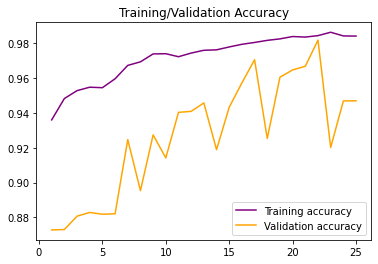

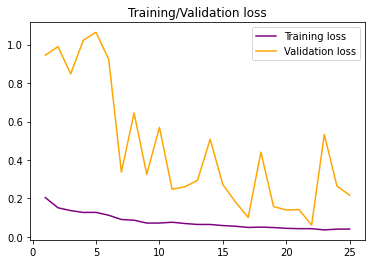

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'purple', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label = 'Validation accuracy')
plt.title('Training/Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'purple', label = 'Training loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validation loss')
plt.title('Training/Validation loss')
plt.legend()

plt.show()
